In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb

# 读取数据集
data = pd.read_csv("/root/2023mcm/new_data.csv")

from pykalman import KalmanFilter
# 选取需要处理的列
cols = [6, 7, 8, 9, 10, 11, 12]
data_sub = data.iloc[:, cols].values

# 创建Kalman滤波器
kf = KalmanFilter(initial_state_mean=data_sub[0], n_dim_obs=7)
# 进行滤波
filtered_state_means, filtered_state_covariances = kf.filter(data_sub)

# 将滤波结果保存回原数据中
data.iloc[:, cols] = filtered_state_means

# 准备数据集
X = data.iloc[:, [1,12, 13, 14, 15, 16, 17, 19,20,21]].values
y = data.iloc[:, 5:12].values
scaler_X = MinMaxScaler()
scaler_y=MinMaxScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 初始化XGBoost模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0,
                        reg_lambda= 6.0, reg_alpha= 0.8,gamma= 0, colsample_bytree=0.5)
# 训练模型
model.fit(X_train, y_train)

# 评估模型
train_loss = np.sqrt(np.mean((model.predict(X_train) - y_train)**2))
test_loss = np.sqrt(np.mean((model.predict(X_test) - y_test)**2))


# 打印损失
print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")



Train Loss: 0.1216, Test Loss: 0.1477


In [2]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 定义要搜索的参数范围
param_grid = {
    'max_depth': [3,5,8,10],
    'learning_rate': [0.1,0.01],
    'n_estimators': [50, 100, 200],
    'gamma': [0,0.3,0.5,0.8],
    'subsample': np.linspace(0.5, 1, num=6),
    'colsample_bytree': np.linspace(0.5, 1, num=6),
    'reg_alpha': np.linspace(0, 1, num=11),
    'reg_lambda': np.linspace(0, 10, num=11)
}

# 初始化 XGBRegressor 模型
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# 初始化 RandomizedSearchCV 搜索器
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=1, random_state=42)


# 执行搜索
random_search.fit(X_train, y_train)

# 打印最佳参数和最佳得分
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)



Best parameters:  {'subsample': 1.0, 'reg_lambda': 6.0, 'reg_alpha': 0.8, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}
Best score:  0.0064818832835286415


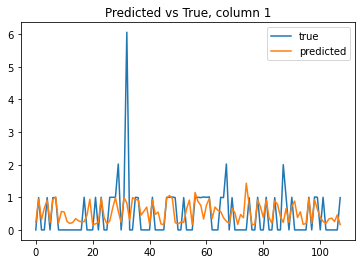

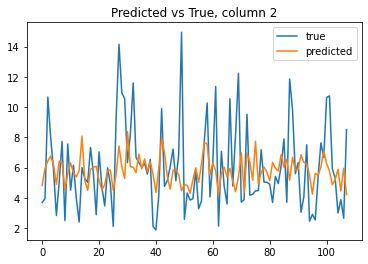

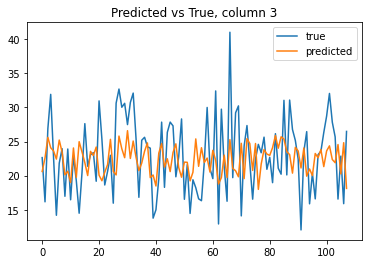

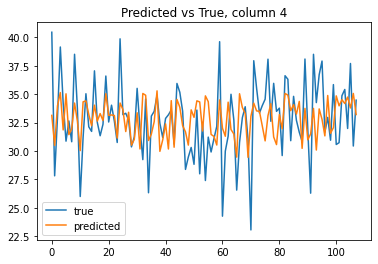

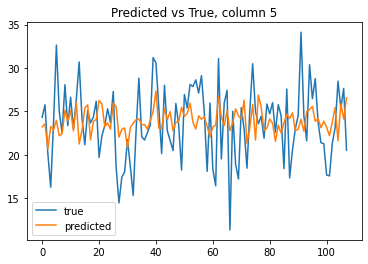

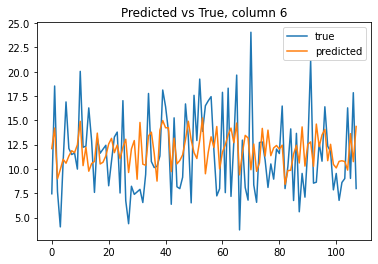

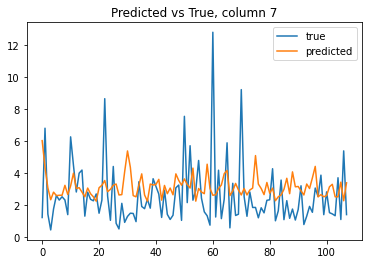

array([[ 0.23613748,  4.817962  , 20.611973  , 33.13326   , 23.227795  ,
        12.096339  ,  6.006663  ],
       [ 0.9461553 ,  5.9507055 , 22.601852  , 30.493958  , 23.564756  ,
        14.209535  ,  4.3378267 ],
       [ 0.30832517,  6.4451914 , 25.612003  , 33.976063  , 20.698658  ,
         8.984603  ,  3.060741  ],
       [ 0.66948795,  6.759203  , 24.084496  , 35.14175   , 23.25961   ,
         9.9466715 ,  2.3111696 ],
       [ 0.9134664 ,  6.1797695 , 23.62842   , 31.856762  , 22.890474  ,
        10.997457  ,  2.7875803 ],
       [ 0.22529179,  4.8918643 , 22.427021  , 35.03171   , 23.962496  ,
        10.587572  ,  2.5713627 ],
       [ 0.9354625 ,  6.430745  , 25.217136  , 31.439898  , 22.20452   ,
        11.32572   ,  2.5931578 ],
       [ 1.0094512 ,  6.31891   , 23.45424   , 31.94937   , 22.414886  ,
        11.873963  ,  2.5931578 ],
       [ 0.208492  ,  4.573109  , 20.125734  , 34.219284  , 25.152498  ,
        11.677135  ,  3.2132933 ],
       [ 0.5659788 ,  5.5849

In [4]:
# 对测试集进行测试
y_pred = model.predict(X_test)

# 反归一化
#scaler.fit(y_test)
y_test = scaler_y.inverse_transform(y_test)
y_pred = scaler_y.inverse_transform(y_pred)

# 绘制预测值和真实值的对比图
for i in range(y_test.shape[1]):
    plt.plot(y_test[:, i], label='true')
    plt.plot(y_pred[:, i], label='predicted')
    plt.legend()
    plt.title(f"Predicted vs True, column {i+1}")
    plt.show()
y_pred


Dimension 1: MSE = 19.195426643615118, RMSE = 4.381258568449837, MAE = 2.64811400665999
Dimension 2: MSE = 2269.7513516535005, RMSE = 47.641907514849784, MAE = 35.517856761044705
Dimension 3: MSE = 28070.023956741414, RMSE = 167.54111124360318, MAE = 136.5571131599227
Dimension 4: MSE = 4262.149748877277, RMSE = 65.2851418691671, MAE = 50.31613798247726
Dimension 5: MSE = 10688.555931431576, RMSE = 103.38547253570772, MAE = 82.243226822997
Dimension 6: MSE = 8573.237813601843, RMSE = 92.59178048618486, MAE = 74.92286136946943
Dimension 7: MSE = 3818.8512017123026, RMSE = 61.796854302725656, MAE = 46.32422889769373


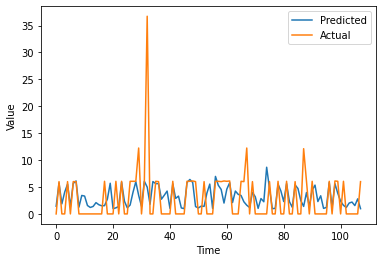

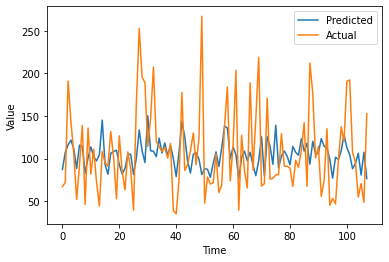

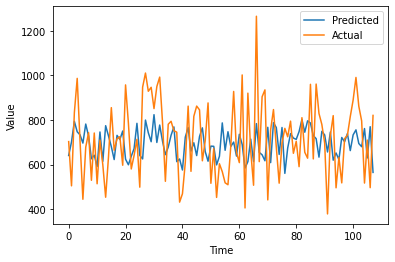

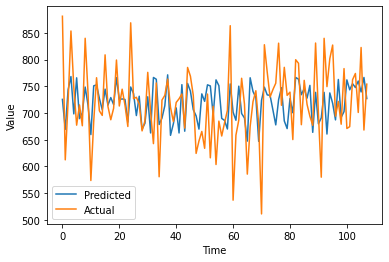

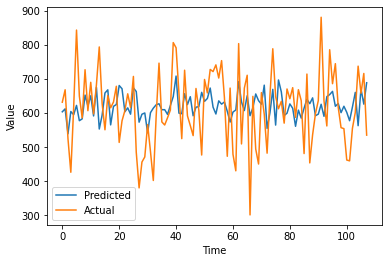

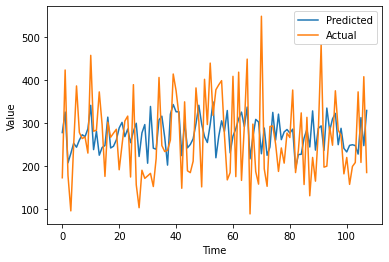

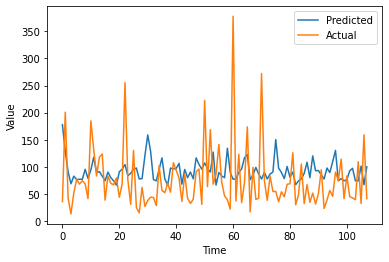

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#scaler.fit(y)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)
df = pd.read_csv("/root/2023mcm/result.csv")
# Create the "GRU" column and assign the predicted values to it
# 计算每个维度的 MSE、RMSE 和 MAE
for i in range(7):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    print("Dimension {}: MSE = {}, RMSE = {}, MAE = {}".format(i+1, mse, rmse, mae))
# 将每个维度的预测值和实际值都分别可视化
for i in range(7):
    plt.plot(y_pred[:, i], label="Predicted")
    plt.plot(y_test[:, i], label="Actual")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

In [6]:
import stats
#对于给定的输入 X，进行预测
X_new = np.array([[620,0, 1, 0, 3, 1, 1, 1,0.09318,0.099]]) # 举例子
X_new = scaler_X.transform(X_new) # 归一化
# 预测
y_pred = model.predict(X_new)

# 反归一化
y_pred_orig = scaler_y.inverse_transform(y_pred)

# 打印预测结果
print("预测结果：")
print(y_pred_orig)

预测结果：
[[ 1.8873565  7.1258245 25.00998   31.124655  24.092382  14.709336
   5.2613564]]


In [9]:
from scipy import stats

def get_confidence_interval(model, X, alpha=0.05):
    """
    给定模型和输入，计算预测值和置信区间
    :param model: 已训练的模型
    :param X: 输入，形状为 (n_samples, n_features)
    :param alpha: 置信水平，默认为 0.05
    :return: 预测值、置信区间下界、置信区间上界
    """
    model.eval() # 模型评估模式
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device) # 转换为张量并放到 GPU 上（如果有）
        y_pred = model(X_tensor).cpu().numpy() # 将预测值转换为 numpy 数组
        n_samples = len(X)
        df = n_samples - model.hidden_size - 1 # 自由度
        se = np.sqrt(np.sum((model(X_tensor).cpu().numpy() - y)**2) / df) # 标准误差
        t = stats.t.ppf(1 - alpha/2, df) # t 分布的分位数
        lower = y_pred - t * se # 置信区间下界
        upper = y_pred + t * se # 置信区间上界
    return y_pred, lower, upper

y_pred, lower, upper = get_confidence_interval(model, X_new)
print("预测值为：", y_pred)
print("置信区间为：[{}, {}]".format(lower, upper))

AttributeError: 'XGBRegressor' object has no attribute 'eval'